In [23]:
from    MCForecastTools        import MCSimulation
from    dateutil.relativedelta import *
from    fredapi                import Fred
from    dotenv                 import load_dotenv
import  numpy                  as     np
import  pandas                 as     pd
import  plotly.express         as     px
import  matplotlib.pyplot      as     plt
import  hvplot.pandas
import  calendar
import  datetime
import  requests
import  os

plt.style.use("fivethirtyeight")
color_pal = plt.rcParams["axes.prop_cycle"].by_key()["color"]
pd.set_option("max_columns", 500)

In [24]:
# Define constants
CRYPTO_ENDPOINT = "https://api.alternative.me/v2/"

### Try to download coin data from alternative.me

In [25]:
# Let's try to get listings

response = requests.get(
    url=CRYPTO_ENDPOINT + "listings/"
)
crypto_list = response.json()["data"]

In [26]:
crypto_list[0]

{'id': '1', 'name': 'Bitcoin', 'symbol': 'BTC', 'website_slug': 'bitcoin'}

In [27]:
coin_params = {
    "limit" : 0,
    "structure" : "array",
    "sort" : "percent_change_24h",
    "convert" : "USD"
}
response = requests.get(
    url=CRYPTO_ENDPOINT + "ticker/",
    params=coin_params
)
ticker = response.json()


In [28]:
len(ticker["data"])

500

In [29]:
df = pd.DataFrame(ticker["data"])

In [30]:
df.head()

,id,name,symbol,website_slug,rank,circulating_supply,total_supply,max_supply,quotes,last_updated
0,2455,PressOne,PRS,pressone,4053,0,0,2000000000,"{'USD': {'price': 0.03500153, 'volume_24h': 24...",1627299941
1,11953,Unifi Protocol DAO,UNFI,unifi-protocol-dao,418,5716364,5716364,10000000,"{'USD': {'price': 22.99, 'volume_24h': 1191214...",1654646295
2,10400,r/FortNiteBR Bricks,BRICK,brick,5747,0,0,0,"{'USD': {'price': 0.0426695, 'volume_24h': 45,...",1653587919
3,2850,Traxia,TMT,traxia,1724,476441306,476441306,1000000000,"{'USD': {'price': 0.00087897, 'volume_24h': 44...",1653587940
4,11910,TronSecureHybrid,TSCHYBRID,tronsecurehybrid,5122,0,0,499700000,"{'USD': {'price': 6.002e-05, 'volume_24h': 81,...",1627330316


In [31]:
df["date_updated"] = pd.to_datetime(df["last_updated"], unit="s")

In [32]:
df.head()

,id,name,symbol,website_slug,rank,circulating_supply,total_supply,max_supply,quotes,last_updated,date_updated
0,2455,PressOne,PRS,pressone,4053,0,0,2000000000,"{'USD': {'price': 0.03500153, 'volume_24h': 24...",1627299941,2021-07-26 11:45:41
1,11953,Unifi Protocol DAO,UNFI,unifi-protocol-dao,418,5716364,5716364,10000000,"{'USD': {'price': 22.99, 'volume_24h': 1191214...",1654646295,2022-06-07 23:58:15
2,10400,r/FortNiteBR Bricks,BRICK,brick,5747,0,0,0,"{'USD': {'price': 0.0426695, 'volume_24h': 45,...",1653587919,2022-05-26 17:58:39
3,2850,Traxia,TMT,traxia,1724,476441306,476441306,1000000000,"{'USD': {'price': 0.00087897, 'volume_24h': 44...",1653587940,2022-05-26 17:59:00
4,11910,TronSecureHybrid,TSCHYBRID,tronsecurehybrid,5122,0,0,499700000,"{'USD': {'price': 6.002e-05, 'volume_24h': 81,...",1627330316,2021-07-26 20:11:56


### Remove coins with no circulation

In [33]:
df = df.loc[df["total_supply"] != 0]

In [34]:
df.head()

,id,name,symbol,website_slug,rank,circulating_supply,total_supply,max_supply,quotes,last_updated,date_updated
1,11953,Unifi Protocol DAO,UNFI,unifi-protocol-dao,418,5716364,5716364,10000000,"{'USD': {'price': 22.99, 'volume_24h': 1191214...",1654646295,2022-06-07 23:58:15
3,2850,Traxia,TMT,traxia,1724,476441306,476441306,1000000000,"{'USD': {'price': 0.00087897, 'volume_24h': 44...",1653587940,2022-05-26 17:59:00
8,2775,Faceter,FACE,face,963,532000000,532000000,1000000000,"{'USD': {'price': 0.00101752, 'volume_24h': 71...",1653588126,2022-05-26 18:02:06
9,10269,BarterTrade,BART,bartertrade,1207,114804357,114804357,240000000,"{'USD': {'price': 0.00496436, 'volume_24h': 29...",1653588215,2022-05-26 18:03:35
11,1556,chrono.tech,TIME,chronobank,623,710113,710113,710113,"{'USD': {'price': 143.94, 'volume_24h': 212709...",1658091568,2022-07-17 20:59:28


In [35]:
df.shape

(285, 11)

### Get economic data

In [36]:
# Set observation start date
start_date = "2018/01/01"

In [37]:
# Retrieve API keys
fred_api_key = os.getenv("FRED_API_KEY")
if not(fred_api_key):
    print("Failed to load API credentials")

In [38]:
fred = Fred(api_key=fred_api_key)
sp500 = fred.get_series("SP500", observation_start=start_date)

In [39]:
display(sp500.head())
display(sp500.tail())

2018-01-01        NaN
2018-01-02    2695.81
2018-01-03    2713.06
2018-01-04    2723.99
2018-01-05    2743.15
dtype: float64

2022-10-20    3665.78
2022-10-21    3752.75
2022-10-24    3797.34
2022-10-25    3859.11
2022-10-26    3830.60
dtype: float64

In [40]:
sp500 = sp500.dropna().copy()

<AxesSubplot:title={'center':'S&P 500'}>

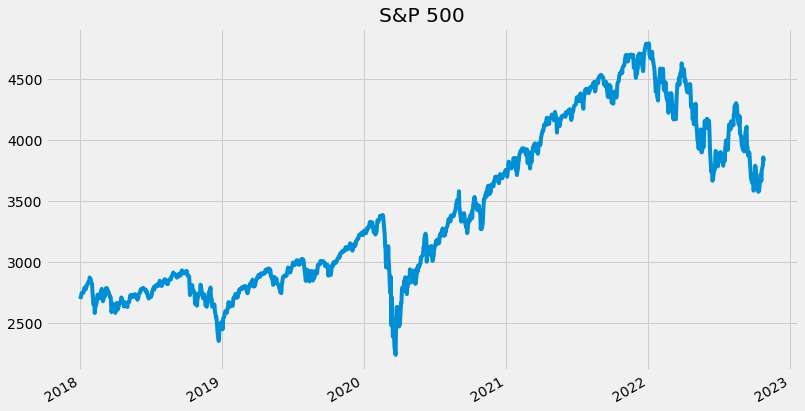

In [41]:
sp500.plot(figsize=(12, 7), title="S&P 500")

### Get unemployment data

In [42]:
# Seasonally adjusted
unemployment_df = fred.get_series("UNRATE", observation_start=start_date)

In [43]:
display(unemployment_df.head())
display(unemployment_df.tail())

2018-01-01    4.0
2018-02-01    4.1
2018-03-01    4.0
2018-04-01    4.0
2018-05-01    3.8
dtype: float64

2022-05-01    3.6
2022-06-01    3.6
2022-07-01    3.5
2022-08-01    3.7
2022-09-01    3.5
dtype: float64

In [44]:
unemployment_df.isna().sum()

0

<AxesSubplot:title={'center':'US Unemployment Rate'}>

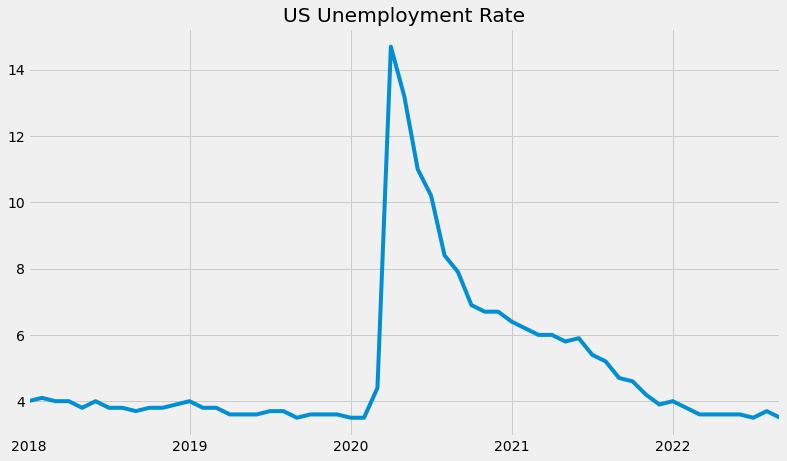

In [45]:
unemployment_df.plot(figsize=(12, 7), title="US Unemployment Rate")

### Search for CPI data

In [46]:
cpi_df = fred.get_series("CPIAUCSL", observation_start=start_date)

In [47]:
display(cpi_df.head())
display(cpi_df.tail())

2018-01-01    248.743
2018-02-01    249.439
2018-03-01    249.581
2018-04-01    250.146
2018-05-01    250.779
dtype: float64

2022-05-01    291.474
2022-06-01    295.328
2022-07-01    295.271
2022-08-01    295.620
2022-09-01    296.761
dtype: float64

In [48]:
cpi_df.isna().sum()

0

<AxesSubplot:title={'center':'US Consumer Price Index'}>

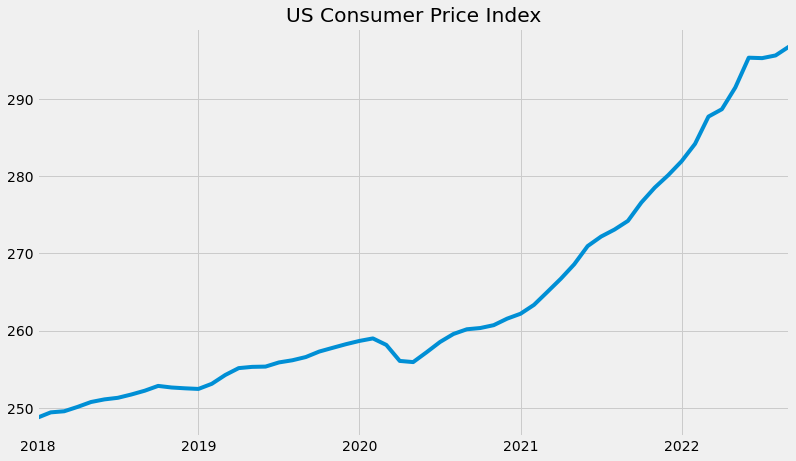

In [49]:
cpi_df.plot(figsize=(12, 7), title="US Consumer Price Index")

### Get GDP

In [50]:
gdp_df = fred.get_series("GDPC1", observation_start=start_date)

In [51]:
display(gdp_df.head())
display(gdp_df.tail())

2018-01-01    18437.127
2018-04-01    18565.697
2018-07-01    18699.748
2018-10-01    18733.741
2019-01-01    18835.411
dtype: float64

2021-04-01    19544.248
2021-07-01    19672.594
2021-10-01    20006.181
2022-01-01    19924.088
2022-04-01    19895.271
dtype: float64

In [52]:
gdp_df.isna().sum()

0

<AxesSubplot:title={'center':'US Real Gross Domestic Product'}>

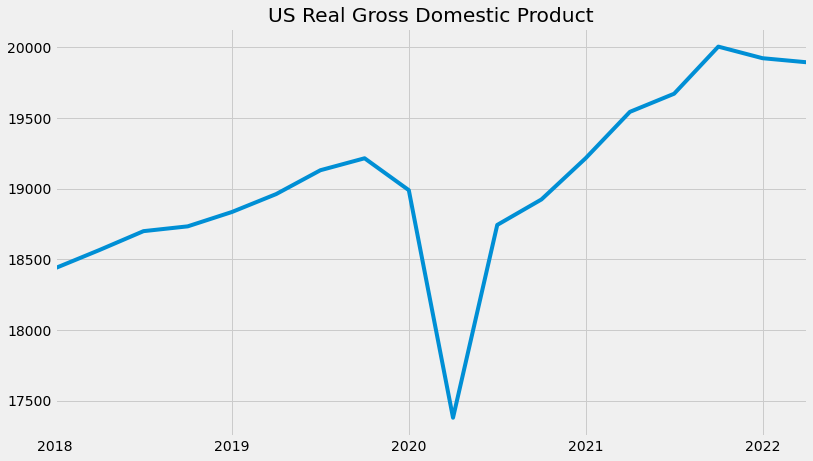

In [53]:
gdp_df.plot(figsize=(12, 7), title="US Real Gross Domestic Product")

### US Interest rates

In [54]:
int_df = fred.get_series("DFF", observation_start=start_date)

In [55]:
display(int_df.head())
display(int_df.tail())

2018-01-01    1.33
2018-01-02    1.42
2018-01-03    1.42
2018-01-04    1.42
2018-01-05    1.42
dtype: float64

2022-10-21    3.08
2022-10-22    3.08
2022-10-23    3.08
2022-10-24    3.08
2022-10-25    3.08
dtype: float64

In [56]:
int_df.isna().sum()

0

<AxesSubplot:title={'center':'US Federal Reserve Effective Rate'}>

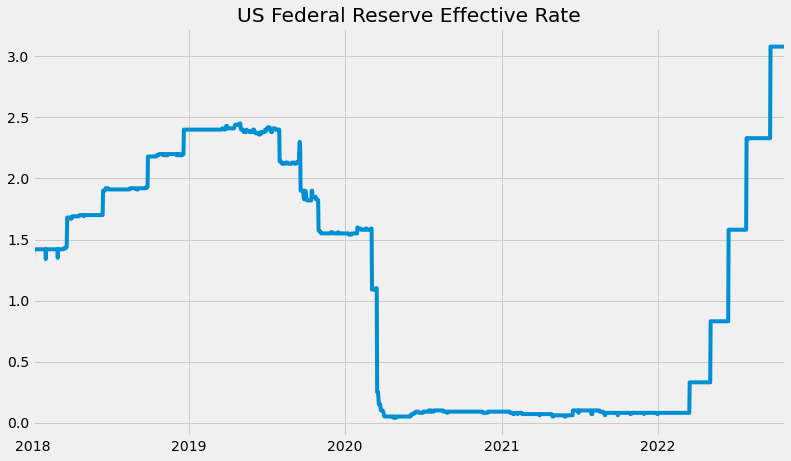

In [57]:
int_df.plot(figsize=(12, 7), title="US Federal Reserve Effective Rate")

### Unemployment benefit claims

In [58]:
unemployment_claims_df = fred.get_series("ICSA", observation_start=start_date)

In [59]:
display(unemployment_claims_df.head())
display(unemployment_claims_df.tail())

2018-01-06    252000.0
2018-01-13    224000.0
2018-01-20    227000.0
2018-01-27    223000.0
2018-02-03    213000.0
dtype: float64

2022-09-17    209000.0
2022-09-24    190000.0
2022-10-01    219000.0
2022-10-08    226000.0
2022-10-15    214000.0
dtype: float64

In [60]:
unemployment_claims_df.isna().sum()

0

<AxesSubplot:title={'center':'US Weekly Unemployment Insurance Claims'}>

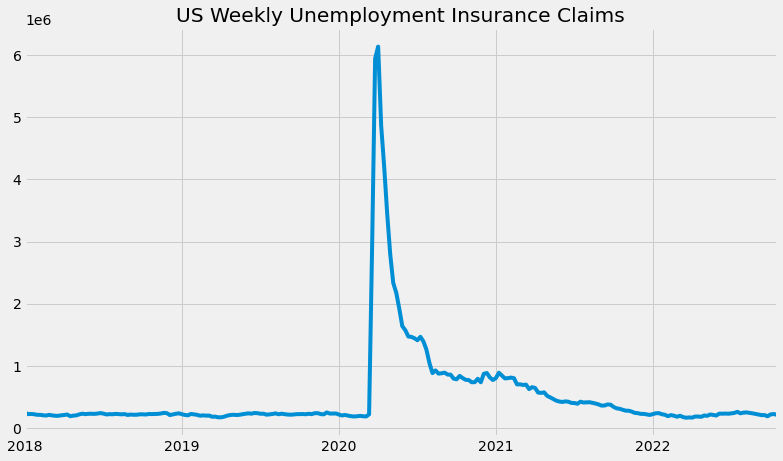

In [61]:
unemployment_claims_df.plot(figsize=(12, 7), title="US Weekly Unemployment Insurance Claims")

### Get labour force participation

In [62]:
labour_df = fred.get_series("CIVPART", observation_start=start_date)

In [63]:
display(labour_df.head())
display(labour_df.tail())

2018-01-01    62.7
2018-02-01    63.0
2018-03-01    62.9
2018-04-01    62.9
2018-05-01    62.9
dtype: float64

2022-05-01    62.3
2022-06-01    62.2
2022-07-01    62.1
2022-08-01    62.4
2022-09-01    62.3
dtype: float64

In [64]:
labour_df.isna().sum()

0

<AxesSubplot:title={'center':'US Labour Force Participation'}>

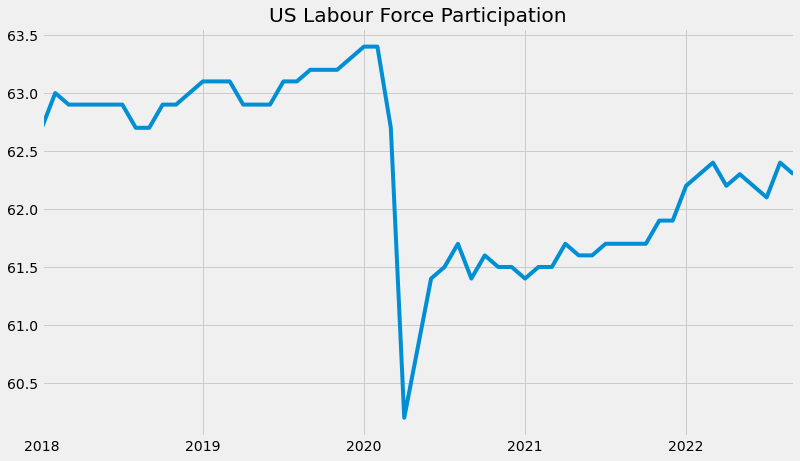

In [65]:
labour_df.plot(figsize=(12, 7), title="US Labour Force Participation")

### Collect economic data into merged visualisation

Text(0.5, 1.0, 'Unemployment vs Participation Rate')

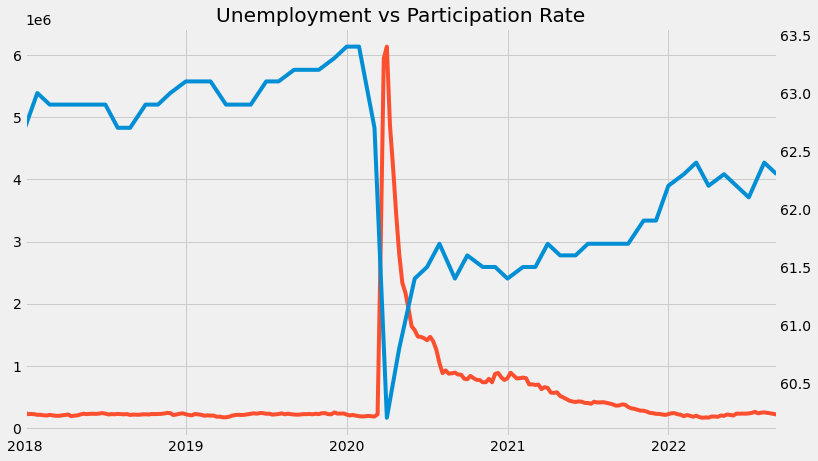

In [66]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
unemployment_claims_df.plot(ax=ax, label="Unemployment", color=color_pal[1])
labour_df.plot(ax=ax2, label="Participation", color=color_pal[0])
ax2.grid(False)
ax.set_title("Unemployment vs Participation Rate")

Text(0.5, 1.0, 'Interest Rate vs Participation Rate')

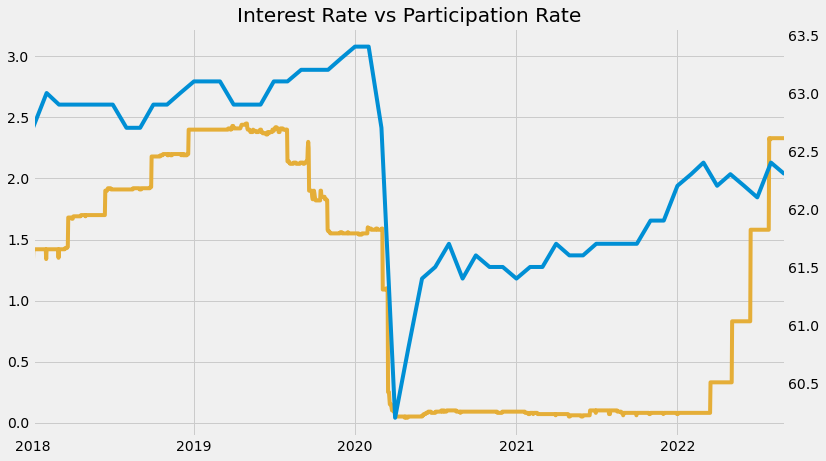

In [67]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
int_df.plot(ax=ax, label="US Federal Reserve Effective Rate", color=color_pal[2])
labour_df.plot(ax=ax2, label="Participation", color=color_pal[0])
ax2.grid(False)
ax.set_title("Interest Rate vs Participation Rate")

Text(0.5, 1.0, 'Gross Domestic Product vs Participation Rate')

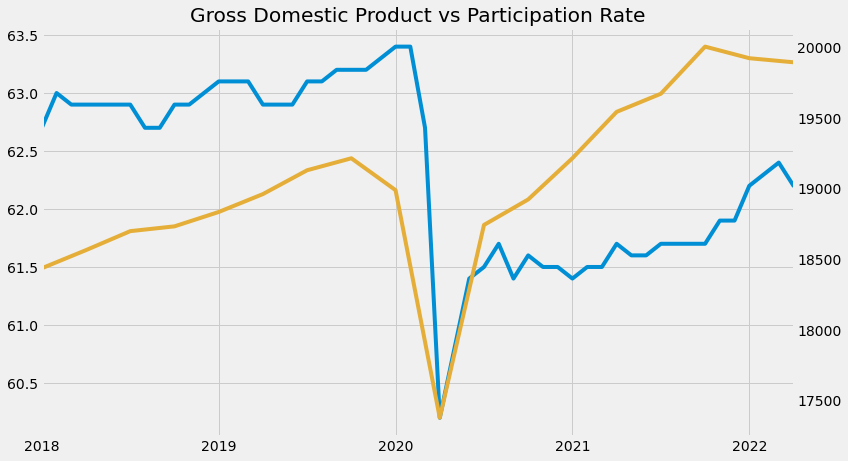

In [68]:
fig, ax = plt.subplots(figsize=(12, 7))
ax2 = ax.twinx()
labour_df.plot(ax=ax, label="Participation Rate", color=color_pal[0])
gdp_df.plot(ax=ax2, label="US Real GDP", color=color_pal[2])
ax2.grid(False)
ax.set_title("Gross Domestic Product vs Participation Rate")